---
title: "HDA Extreme DT Parameter Plotter - Tutorial"
subtitle: "This notebook shows how to select, request, and download Climate Digital Twin Extremes data from the DestinE Data Lake (DEDL HDA), including user-defined parameter, scenario, date, and level selection, followed by secure authentication, API querying, and visualization using EarthKit."
author: "Author: Eumetsat"
tags: [ECMWF, earthkit, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2024 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE%20Digital%20Twins/ExtremeDT-ParameterPlotter.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

**Credit**: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example to access and plot Extreme DT parameter.</br>

[Documentation DestinE DataLake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Introduction-to-Discovery-and-Data-Access-services/Introduction-to-Discovery-and-Data-Access-services.html#hda-harmonised-data-access)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)


## Import the required packages

Import the Climate DT parameter & scenario dictionary

In [1]:
from destinelab import extreme_dt_dictionary
import ipywidgets as widgets
import json
from datetime import datetime, timedelta

## Extreme DT parameter selection (we limit the plotting to one parameter)

In [3]:
# Create search box
search_box = widgets.Text(placeholder='Search by parameter name', description='Search:', disabled=False)

# Create dropdown to select entry
entry_dropdown = widgets.Dropdown(
    options=[(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)],
    description='Select Entry:'
)

def filter_entries(search_string):
    return [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params) if search_string.lower() in entry['paramName'].lower()]

def on_search_change(change):
    search_string = change.new
    if search_string:
        filtered_options = filter_entries(search_string)
        entry_dropdown.options = filtered_options
    else:
        entry_dropdown.options = [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)]

search_box.observe(on_search_change, names='value')

# Display widgets
display(search_box, entry_dropdown)

def get_selected_entry():
    return entry_dropdown.value


Text(value='', description='Search:', placeholder='Search by parameter name')

Dropdown(description='Select Entry:', options=(('Sea ice area fraction', 0), ('Sea surface temperature', 1), (…

# Print the details of the parameter (Polytope convention):

In [4]:

selected_index = get_selected_entry()
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
print(json.dumps(selected_entry,indent=4))

{
    "param": "167",
    "paramName": "2 metre temperature",
    "shortName": "2t",
    "unit": "K",
    "encoding": "instantaneous",
    "stream": "oper",
    "type": "fc",
    "levtype": "sfc",
    "step": "0/1/to/96",
    "levelist": ""
}


## Select the Date of Observation to be selected

Extremes DT data that is older than 15 days is archived, below it is then possible to choose only dates in the last 15 days.

To choose your date, please consider also the current Extremes DT data availability. Extremes DT data availability can be find out using the ExtremeDT-dataAvailability.ipynb in this folder.

In [5]:
from datetime import datetime, timedelta

# Get the current date and time in UTC
current_date = datetime.utcnow()

# Calculate the date 15 days before the current date
date_15_days_ago = current_date - timedelta(days=15)

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = date_15_days_ago.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_from = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = current_date.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_to = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

In [6]:
from ipywidgets import Label
# Create dropdown to select scenario
scenario_dropdown = widgets.Dropdown(
    options=[(f"{entry['model']}", (i)) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_scenario)],
    description='Scenario:'
)

# Create date picker widgets
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

def on_scenario_change(change):
    print("scenario_change")
    selected_index = change.new
    selected_entry = extreme_dt_dictionary.extremeDT_scenario[selected_index]
    start_date_picker.min = date_from
    start_date_picker.max = date_to
    # Set the initial date of the start_date_picker to the scenario's start date
    start_date_picker.value = date_to
    selected_start_date = start_date_picker.value
    
scenario_dropdown.observe(on_scenario_change, names='value')

# Set initial values directly
selected_entry = extreme_dt_dictionary.extremeDT_scenario[0]

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = date_to
start_date_picker.value = date_to

# Display widgets

def get_selected_values():
    selected_scenario_index = scenario_dropdown.value
    selected_scenario = extreme_dt_dictionary.extremeDT_scenario[selected_scenario_index]
    selected_start_date = start_date_picker.value
    return selected_scenario_index, selected_scenario, selected_start_date

# Display widgets
display(Label("To choose your date, please consider the current Extremes DT data availability (ExtremeDT-dataAvailability.ipynb in this folder)."),scenario_dropdown,  start_date_picker)

# Example usage:
selected_scenario_index, selected_scenario, selected_start_date = get_selected_values()


Label(value='To choose your date, please consider the current Extremes DT data availability (ExtremeDT-dataAva…

Dropdown(description='Scenario:', options=(('IFS-NEMO', 0),), value=0)

DatePicker(value=datetime.date(2025, 5, 9), description='Start Date:', max=datetime.date(2025, 5, 9), min=date…

## Choose now the Steps within the observation to be retrieved (one step usually one hour)

In [7]:
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
input_string = selected_entry["step"]

def parse_input_string(input_string):
    ranges = input_string.split('/')
    step_start = ""
    step_end = ""
    step_width = 1
    hypen = ""
    options = []
    for rng in ranges:
        if rng:
            if '-' in rng:
                hypen = "-"
                start, end = rng.split('-')
                step_width = int(end) - int(start)
                if step_start == "":
                    step_start = int(start.strip())
                step_end = int(end.strip())
            elif 'to' not in rng:
                if step_start == "":
                    step_start = int(rng.strip())
                step_end = int(rng.strip())
                #options.append(option)
    #print(str(step_start) + ":" + str(step_end))
    if hypen != "":
        options.extend([f"{i}-{i+step_width}" for i in range(step_start, step_end, step_width)])
    else:
        options.extend([f"{i}" for i in range(step_start, step_end+1, step_width)])
    return options

def get_selected_step_values():
    selected_values = multi_select.value
    selected_values_string = "/".join(selected_values)
    return selected_values_string

options = parse_input_string(input_string)

multi_select = widgets.SelectMultiple(
    options=options,
    description='Select (Steps):',
    disabled=False
)

display(multi_select)


SelectMultiple(description='Select (Steps):', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',…

## Handle different Levels to be selected (if any)

In [8]:
# Define a global variable
global global_widget
global_widget = None

if selected_entry["levelist"] != "":
    # Convert levelist string to list of integers
    levelist = list(map(int, selected_entry["levelist"].split('/')))

      
    # Create a function to generate the widget based on the selection mode
    def generate_widget(selection_mode):
        global global_widget
        if selection_mode == 'Single':
            global_widget = widgets.Dropdown(options=levelist, description='Select level:')
            return global_widget
        elif selection_mode == 'Multiple':
            global_widget = widgets.SelectMultiple(options=levelist, description='Select levels:')
            return global_widget

    # Create a dropdown widget to choose selection mode
    selection_mode_dropdown = widgets.Dropdown(options=['Single', 'Multiple'], description='Selection Mode:')

    # Create an output widget to display the selected option(s)
    output = widgets.Output()

    # Function to display the widget based on the selection mode
    def display_widget(selection_mode):
        output.clear_output()
        with output:
            display(generate_widget(selection_mode))

    # Define a function to handle the change in selection mode
    def on_dropdown_change(change):
        display_widget(change.new)

    # Register the function to handle dropdown changes
    selection_mode_dropdown.observe(on_dropdown_change, names='value')

    # Display the widgets
    display(selection_mode_dropdown, output)

    # Display the initial widget based on default selection mode
    display_widget('Single')

In [9]:
# Function to convert tuple or single integer to string separated by "/"
def convert_to_string(input):
    if isinstance(input, tuple):
        return '/'.join(map(str, input))
    elif isinstance(input, int):
        return str(input)
    else:
        return None  # Handle other types if needed

levlInput = ""
if global_widget != None:
    # Test cases
    levlInput = convert_to_string(global_widget.value)


In [10]:
# Call get_selected_values after the display is finished
selected_step_values = get_selected_step_values()

# Print the result in JSON format
#datechoice = get_selected_values()[2].strftime('%Y%m%d')
datechoice = "{fname}T00:00:00Z".format(fname = get_selected_values()[2])

filter_params = {
  "class": "d1",                       # fixed 
  "dataset": "extremes-dt",             # fixed extreme-dt access
  "expver": "0001",                    # fixed experiment version 
  "stream": selected_entry["stream"],
  "type": "fc",                        # fixed forecasted fields
#  "date": datechoice,                  # choose the date
  "time": "0000",                      # fixed 
  "step": selected_step_values,        # step choice 
  "levtype": selected_entry["levtype"],  
  "levelist": str(levlInput),  
  "param": str(selected_entry["param"]),  
}

# Print the result in JSON format
print(datechoice)
print(json.dumps(filter_params, indent=4))

2025-05-08T00:00:00Z
{
    "class": "d1",
    "dataset": "extremes-dt",
    "expver": "0001",
    "stream": "oper",
    "type": "fc",
    "time": "0000",
    "step": "0/1",
    "levtype": "sfc",
    "levelist": "",
    "param": "167"
}


## Obtain Authentication Token

In [11]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import json
import os
from getpass import getpass
import destinelab as deauth

In [13]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [14]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## Query using the DEDL HDA API


### Filter
We have to setup up a filter and define which data to obtain.

In [15]:
# Check if levelist is empty and remove it
if filter_params.get("levelist") == "":
    del filter_params["levelist"]
   
hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}

#print(hdaFilters)



### Make Data Request
Please repeat this call is you have a timeout failure (under investion in the moment)

In [16]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = session.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": hdaFilters
})

# Requests to EO.ECMWF.DAT.DT_EXTREMES always return a single item containing all the requested data
#print(response.json())
product = response.json()["features"][0]
product["id"]

'DT_EXTREMES_20250508_20250508_4f2a321575e01d5094ab9e23ed5e21052f4b79f7'

### Submission worked ? Once our product found, we download the data.

In [17]:
# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = session.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
elif (response.status_code != HTTP_ACCEPTED_CODE):
    print(response.text)
print(download_url)
response.raise_for_status()
    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20250508_20250508_4f2a321575e01d5094ab9e23ed5e21052f4b79f7/download?provider=dedt_lumi&_dc_qs=%257B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522extremes-dt%2522%252C%2B%2522date%2522%253A%2B%252220250508%252Fto%252F20250508%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522param%2522%253A%2B%2522167%2522%252C%2B%2522step%2522%253A%2B%25220%252F1%2522%252C%2B%2522stream%2522%253A%2B%2522oper%2522%252C%2B%2522time%2522%253A%2B%25220000%2522%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D


### Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

**Please note that the basic HDA quota allows a maximum of 4 requests per second. The following code limits polling to this quota.**

In [18]:
pip install ratelimit --quiet

Note: you may need to restart the kernel to use updated packages.


In [19]:
from tqdm import tqdm
import time
import re
from ratelimit import limits, sleep_and_retry

# Set limit: max 4 calls per 1 seconds
CALLS = 4
PERIOD = 1  # seconds

@sleep_and_retry
@limits(calls=CALLS, period=PERIOD)
def call_api(url,auth_headers):
    response = session.get(url, headers=auth_headers, stream=True)
    return response

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = call_api(url,auth_headers)

if (response.status_code not in (HTTP_SUCCESS_CODE,HTTP_ACCEPTED_CODE)):
     (print(response.text))

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response)
    print(response.text)
    raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading 79938f75-be7f-49d7-af32-7127d00c8d87.grib


100%|██████████| 104M/104M [00:04<00:00, 24.8MB/s] 


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [20]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

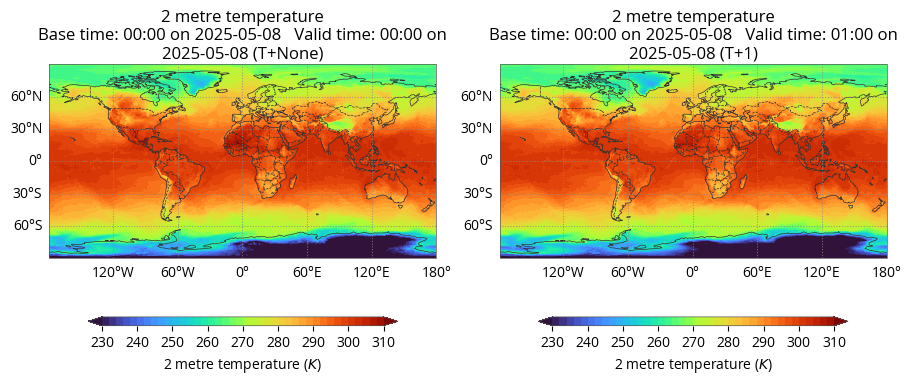

In [21]:
data = earthkit.data.from_source("file", filename)
data.ls

earthkit.maps.quickplot(data, #style=style
                       )